<a href="https://colab.research.google.com/github/Fpadt/AI/blob/main/Lesson_8_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install --upgrade statsforecast
!pip install --upgrade utilsforecast

!pip install dtype_diet -q

In [ ]:
import os
from functools import partial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go

from plotly.subplots import make_subplots

from statsforecast import StatsForecast
from statsforecast.feature_engineering import mstl_decomposition
from statsforecast.models import ARIMA, MSTL

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape, mase
from utilsforecast.plotting import plot_series

from dtype_diet import report_on_dataframe, optimize_dtypes

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/valeman/Mastering-Modern-Time-Series-Forecasting-The-Complete-Guide/refs/heads/main/datasets/vn1/Phase%200%20-%20Sales.csv')

In [ ]:
data.head()

,Client,Warehouse,Product,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,2020-08-17,...,2023-07-31,2023-08-07,2023-08-14,2023-08-21,2023-08-28,2023-09-04,2023-09-11,2023-09-18,2023-09-25,2023-10-02
0,0,1,367,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0
1,0,1,639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,5.0,5.0,6.0,5.0,1.0,2.0,2.0,18.0,2.0
2,0,1,655,21.0,21.0,21.0,25.0,35.0,35.0,35.0,...,9.0,4.0,2.0,9.0,8.0,6.0,0.0,17.0,21.0,37.0
3,0,1,1149,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,1.0,1.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0
4,0,1,1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,23.0,2.0,1.0,1.0,2.0,0.0,22.0,10.0,6.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15053 entries, 0 to 15052
Columns: 173 entries, Client to 2023-10-02
dtypes: float64(170), int64(3)
memory usage: 19.9 MB


In [ ]:
proposed_df = report_on_dataframe(data, unit="MB")
print(f'Original df memory: {data.memory_usage(deep=True).sum()/1024/1024} MB')

data = optimize_dtypes(data, proposed_df)
print(f'Proposed df memory: {data.memory_usage(deep=True).sum()/1024/1024} MB')

Original df memory: 19.868358612060547 MB
Proposed df memory: 9.747618675231934 MB


In [ ]:
data.dtypes

,0
Client,int8
Warehouse,int16
Product,int16
2020-07-06,float32
2020-07-13,float32
...,...
2023-09-04,float32
2023-09-11,float32
2023-09-18,float32
2023-09-25,float32


In [ ]:
data.columns

Index(['Client', 'Warehouse', 'Product', '2020-07-06', '2020-07-13',
       '2020-07-20', '2020-07-27', '2020-08-03', '2020-08-10', '2020-08-17',
       ...
       '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28',
       '2023-09-04', '2023-09-11', '2023-09-18', '2023-09-25', '2023-10-02'],
      dtype='object', length=173)

In [ ]:
time_columns = list(data.columns)[3:]
#time_columns

In [ ]:
# Assuming df is your DataFrame
data[time_columns] = data[time_columns].astype('int32')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15053 entries, 0 to 15052
Columns: 173 entries, Client to 2023-10-02
dtypes: int16(2), int32(170), int8(1)
memory usage: 9.8 MB


In [ ]:
data['unique_id'] = data['Client'].astype(str) + '_' + data['Warehouse'].astype(str) + '_' + data['Product'].astype(str)

In [ ]:
# make last column the first one
data = data[[data.columns[-1]] + list(data.columns[:-1])]
data.head()

,unique_id,Client,Warehouse,Product,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,...,2023-07-31,2023-08-07,2023-08-14,2023-08-21,2023-08-28,2023-09-04,2023-09-11,2023-09-18,2023-09-25,2023-10-02
0,0_1_367,0,1,367,7,7,7,7,7,7,...,1,0,1,0,1,1,0,0,7,0
1,0_1_639,0,1,639,0,0,0,0,0,0,...,3,5,5,6,5,1,2,2,18,2
2,0_1_655,0,1,655,21,21,21,25,35,35,...,9,4,2,9,8,6,0,17,21,37
3,0_1_1149,0,1,1149,7,7,7,7,7,7,...,1,1,1,0,2,2,2,1,0,1
4,0_1_1485,0,1,1485,0,0,0,0,0,0,...,21,23,2,1,1,2,0,22,10,6


In [ ]:
df = data.drop(columns=['Client', 'Warehouse', 'Product'])
df.head()

,unique_id,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,2020-08-17,2020-08-24,2020-08-31,...,2023-07-31,2023-08-07,2023-08-14,2023-08-21,2023-08-28,2023-09-04,2023-09-11,2023-09-18,2023-09-25,2023-10-02
0,0_1_367,7,7,7,7,7,7,7,7,7,...,1,0,1,0,1,1,0,0,7,0
1,0_1_639,0,0,0,0,0,0,0,0,0,...,3,5,5,6,5,1,2,2,18,2
2,0_1_655,21,21,21,25,35,35,35,35,35,...,9,4,2,9,8,6,0,17,21,37
3,0_1_1149,7,7,7,7,7,7,7,7,7,...,1,1,1,0,2,2,2,1,0,1
4,0_1_1485,0,0,0,0,0,0,0,0,0,...,21,23,2,1,1,2,0,22,10,6


In [ ]:
df = df.melt(id_vars=['unique_id'], var_name='ds', value_name='y')
df.head()

,unique_id,ds,y
0,0_1_367,2020-07-06,7
1,0_1_639,2020-07-06,0
2,0_1_655,2020-07-06,21
3,0_1_1149,2020-07-06,7
4,0_1_1485,2020-07-06,0


In [ ]:
# this makes it so that the outputs of the predict methods have the id as a column
# instead of as the index
os.environ['NIXTLA_ID_AS_COL'] = '1'

## 📊 Exploratory Data Analysis (EDA)
In this section, we will explore demand series in the VN1 dataset to:
- Understand demand sparsity, volume levels, and series characteristics
- Identify potential segments: smooth, intermittent, erratic, lumpy
- Compute statistical features: ADI (p), CV², entropy, trend strength, etc.

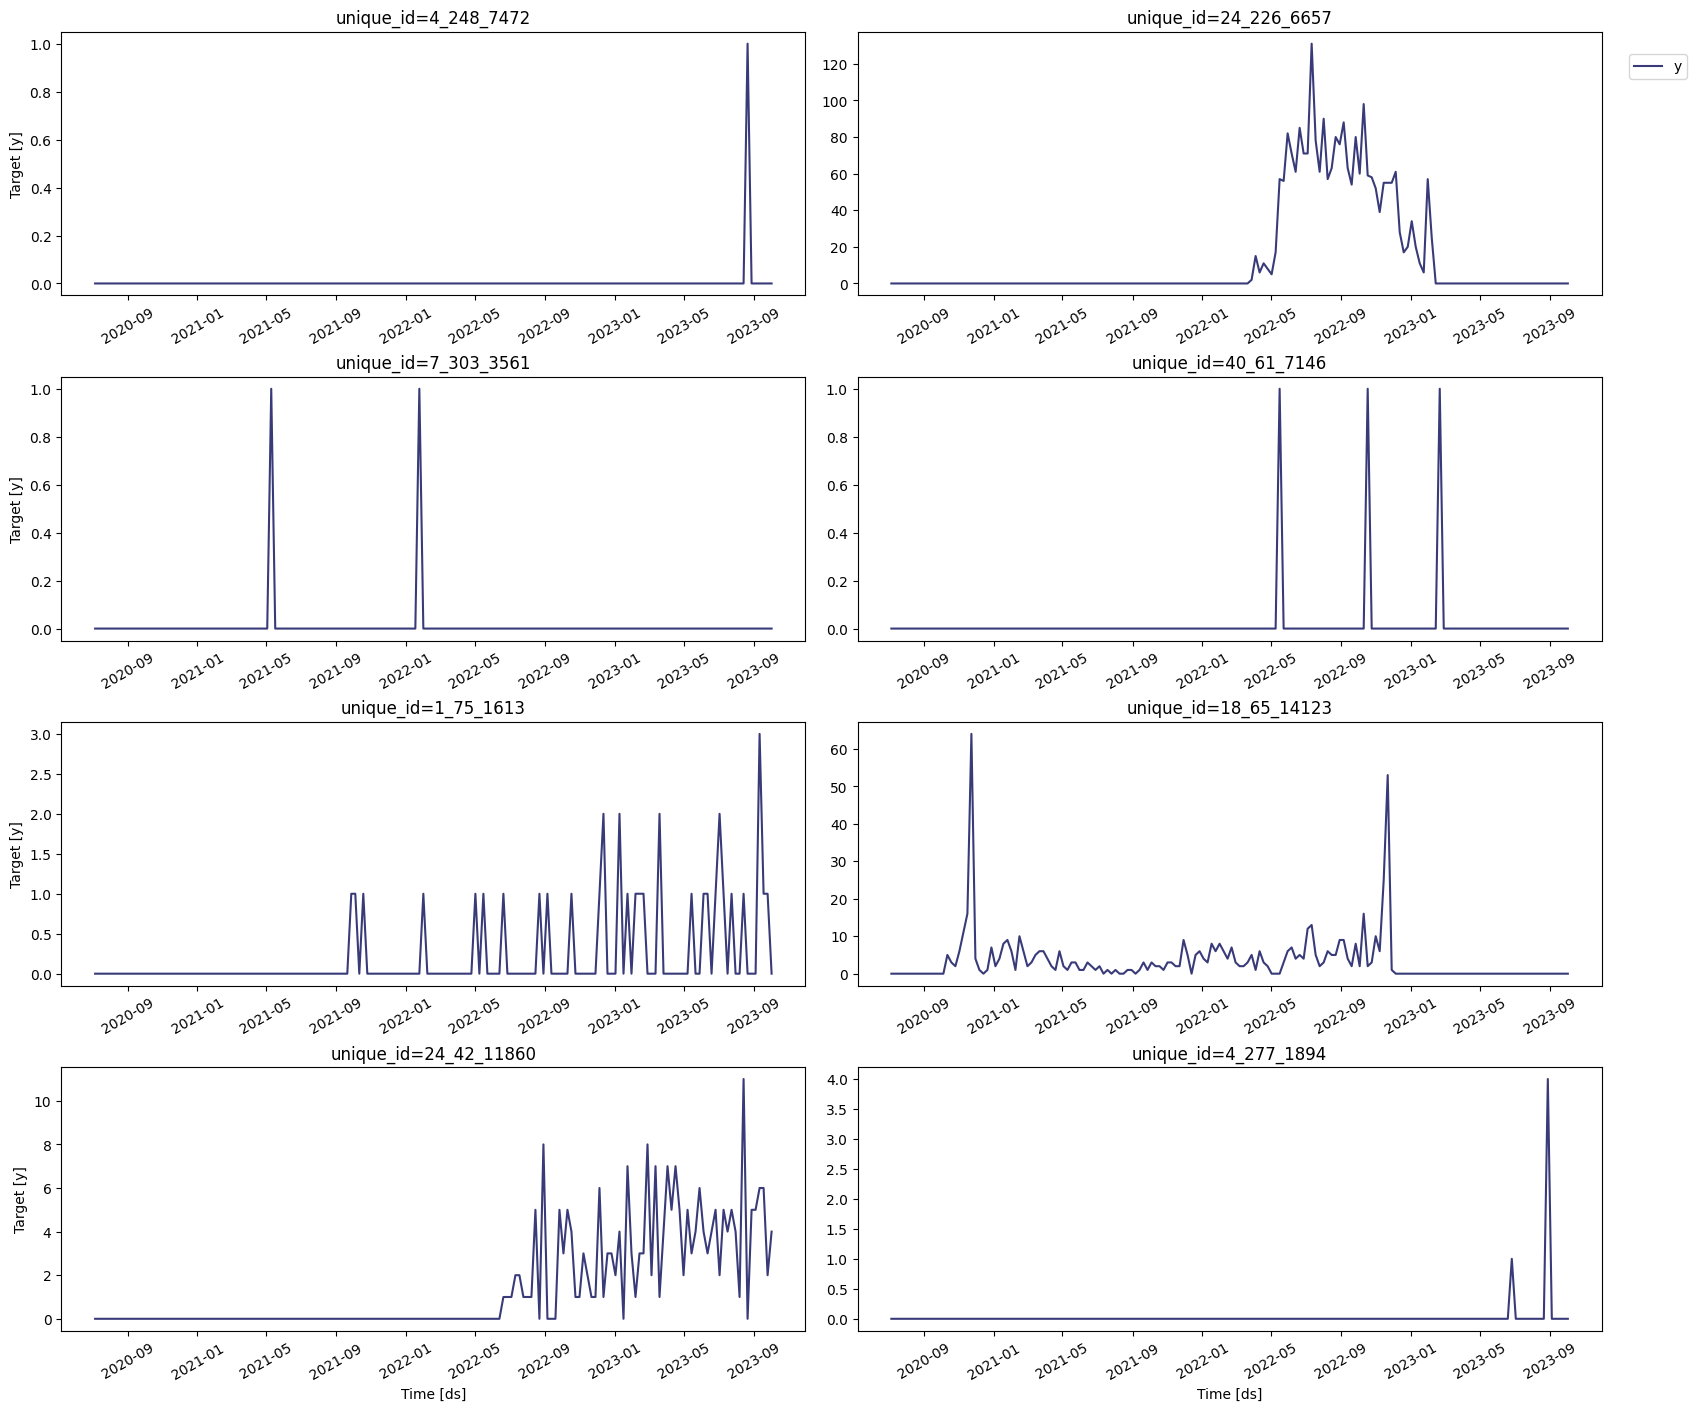

In [ ]:
# Sample N unique series
n_samples = 10
sampled_ids = np.random.choice(df['unique_id'].unique(), size=n_samples, replace=False)

# Filter the DataFrame to include only those series
df_sample = df[df['unique_id'].isin(sampled_ids)]

# Plot using StatsForecast
StatsForecast.plot(df_sample)


In [ ]:
def compute_p(series):
    """
    Compute the average inter-demand interval (p) for a given series.

    Parameters:
    series (pd.Series): The input time series data.

    Returns:
    float: The average inter-demand interval.
    """
    non_zero_indices = np.where(series > 0)[0]
    if len(non_zero_indices) < 2:
        return np.nan  # Not enough non-zero demands to compute intervals

    intervals = np.diff(non_zero_indices)
    return np.mean(intervals)

def compute_cv2(series):
    """
    Compute the squared coefficient of variation (CV2) for a given series.

    Parameters:
    series (pd.Series): The input time series data.

    Returns:
    float: The squared coefficient of variation.
    """
    non_zero_values = series[series > 0]
    if len(non_zero_values) == 0:
        return np.nan  # No non-zero demands to compute CV2

    mean_value = np.mean(non_zero_values)
    std_dev = np.std(non_zero_values)
    return (std_dev / mean_value) ** 2

def classify_demand(p, cv2):
    """
    Classify demand based on p and CV2 values.

    Parameters:
    p (float): Average inter-demand interval.
    cv2 (float): Squared coefficient of variation.

    Returns:
    str: Demand classification ('smooth', 'intermittent', 'erratic', 'lumpy').
    """
    if np.isnan(p) or np.isnan(cv2):
        return 'unclassified'
    if p <= 1.32 and cv2 <= 0.49:
        return 'smooth'
    elif p > 1.32 and cv2 <= 0.49:
        return 'intermittent'
    elif p <= 1.32 and cv2 > 0.49:
        return 'erratic'
    else:
        return 'lumpy'

def classify_demand_in_dataframe(df):
    """
    Classify demand for each series in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame with 'unique_id' and 'y' columns.

    Returns:
    pd.DataFrame: DataFrame with columns 'unique_id', 'p', 'CV2', and 'classification'.
    """
    results = {
        'unique_id': [],
        'p': [],
        'CV2': [],
        'classification': []
    }

    for unique_id, group in df.groupby('unique_id'):
        series = group['y']
        p_value = compute_p(series)
        cv2_value = compute_cv2(series)
        classification = classify_demand(p_value, cv2_value)

        results['unique_id'].append(unique_id)
        results['p'].append(p_value)
        results['CV2'].append(cv2_value)
        results['classification'].append(classification)

    return pd.DataFrame(results)

In [ ]:
classification_result_df = classify_demand_in_dataframe(df)

In [ ]:
classification_result_df

,unique_id,p,CV2,classification
0,0_100_10705,1.090323,0.153636,smooth
1,0_100_10789,1.024845,0.136742,smooth
2,0_100_11015,1.280303,0.150892,smooth
3,0_100_1149,1.388430,0.128525,intermittent
4,0_100_11526,1.204380,0.092080,smooth
...,...,...,...,...
15048,9_82_9800,NaN,0.000000,unclassified
15049,9_82_9804,NaN,0.000000,unclassified
15050,9_82_9829,NaN,0.000000,unclassified
15051,9_82_9838,NaN,0.000000,unclassified


In [ ]:
# Count each classification
classification_counts = classification_result_df['classification'].value_counts().reset_index()
classification_counts.columns = ['classification', 'count']

# Calculate percentage
total = classification_counts['count'].sum()
classification_counts['percentage'] = 100 * classification_counts['count'] / total

# Plot bar chart
fig = px.bar(
    classification_counts,
    x='classification',
    y='count',
    text=classification_counts['percentage'].round(1).astype(str) + '%',
    title='Demand Type Distribution',
    labels={'count': 'Number of Series', 'classification': 'Demand Type'},
    template='plotly_dark'
)

fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()


In [ ]:
data.head()

,unique_id,Client,Warehouse,Product,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,...,2023-07-31,2023-08-07,2023-08-14,2023-08-21,2023-08-28,2023-09-04,2023-09-11,2023-09-18,2023-09-25,2023-10-02
0,0_1_367,0,1,367,7,7,7,7,7,7,...,1,0,1,0,1,1,0,0,7,0
1,0_1_639,0,1,639,0,0,0,0,0,0,...,3,5,5,6,5,1,2,2,18,2
2,0_1_655,0,1,655,21,21,21,25,35,35,...,9,4,2,9,8,6,0,17,21,37
3,0_1_1149,0,1,1149,7,7,7,7,7,7,...,1,1,1,0,2,2,2,1,0,1
4,0_1_1485,0,1,1485,0,0,0,0,0,0,...,21,23,2,1,1,2,0,22,10,6


# Basic data checks

In [ ]:
# check for data issues - are NaNs present?
data.isnull().sum().sum()

np.int64(0)

In [ ]:
data.isnull().sum()

,0
unique_id,0
Client,0
Warehouse,0
Product,0
2020-07-06,0
...,...
2023-09-04,0
2023-09-11,0
2023-09-18,0
2023-09-25,0


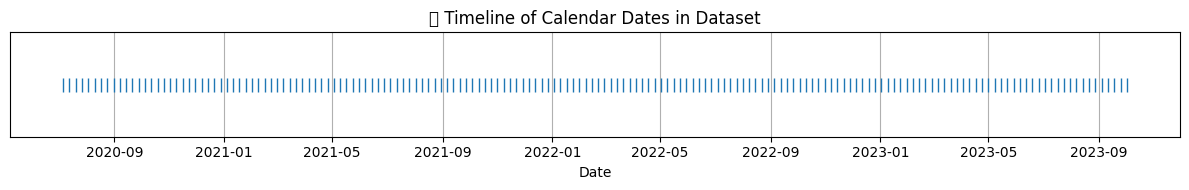

,0


In [ ]:
# Step 1: Convert to datetime
calendar_dates = pd.to_datetime(time_columns, errors='coerce')
calendar_dates = calendar_dates.dropna().sort_values()

# Step 2: Calculate day gaps
date_diffs = calendar_dates.to_series().diff().dt.days
irregular_gaps = date_diffs[date_diffs != 7]

# Step 3: Plot timeline

plt.figure(figsize=(12, 2))
plt.plot(calendar_dates, [1]*len(calendar_dates), '|', markersize=10)
plt.title("🕒 Timeline of Calendar Dates in Dataset")
plt.yticks([])
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Show unexpected gaps
irregular_gaps.dropna()

In [ ]:
# Create a DataFrame for plotting
timeline_df = pd.DataFrame({
    "date": calendar_dates,
    "y": [1] * len(calendar_dates)
})

# Plot as vertical ticks using scatter
fig = px.scatter(
    timeline_df,
    x="date",
    y="y",
    title="🕒 Timeline of Calendar Dates in Dataset",
    labels={"date": "Date"},
    template="plotly_dark"
)

# Format to look like tick marks
fig.update_traces(marker=dict(symbol="line-ns-open", size=15))
fig.update_yaxes(visible=False)
fig.update_layout(showlegend=False, height=200)

fig.show()

In [ ]:
# another option to check for gaps visually

calendar_dates = pd.to_datetime(data.columns[4:])  # wide-format time columns
calendar_dates = pd.Series(sorted(calendar_dates))

# Generate full timeline with weekly frequency
full_range = pd.date_range(start=calendar_dates.min(), end=calendar_dates.max(), freq="W-MON")

# Create cumulative indices
actual_cum = pd.Series(range(1, len(calendar_dates) + 1), index=calendar_dates)
ideal_cum = pd.Series(range(1, len(full_range) + 1), index=full_range)

# Plot
fig = go.Figure()

# Actual dates cumulative
fig.add_trace(go.Scatter(
    x=actual_cum.index,
    y=actual_cum.values,
    mode='lines+markers',
    name='Actual Timeline',
    line=dict(color='cyan')
))

# Ideal 45-degree cumulative line
fig.add_trace(go.Scatter(
    x=ideal_cum.index,
    y=ideal_cum.values,
    mode='lines',
    name='Ideal Timeline (No Gaps)',
    line=dict(dash='dash', color='orange')
))

fig.update_layout(
    title='📈 Cumulative Timeline Check (Actual vs Ideal)',
    xaxis_title='Date',
    yaxis_title='Cumulative Week Count',
    template='plotly_dark',
    height=400
)

fig.show()


In [ ]:
# Assuming `data` is your wide-format DataFrame
# Convert from wide to long format
data_long_df = data.melt(
    id_vars=['unique_id', 'Client', 'Warehouse', 'Product'],
    var_name='ds',
    value_name='y'
)
data_long_df['ds'] = pd.to_datetime(data_long_df['ds'])
data_long_df.head()

,unique_id,Client,Warehouse,Product,ds,y
0,0_1_367,0,1,367,2020-07-06,7
1,0_1_639,0,1,639,2020-07-06,0
2,0_1_655,0,1,655,2020-07-06,21
3,0_1_1149,0,1,1149,2020-07-06,7
4,0_1_1485,0,1,1485,2020-07-06,0


In [ ]:
# Compute total sales across all products per date
total_sales = data_long_df.groupby('ds')['y'].sum().reset_index()

# Plot using Plotly
fig = px.line(
    total_sales,
    x='ds',
    y='y',
    title='🧾 Total Product Sales Over Time',
    labels={'ds': 'Date', 'sales': 'Total Sales'},
    template='plotly_dark'
)
fig.show()


In [ ]:
# Filter to keep only non-zero sales
active_df = data_long_df[data_long_df['y'] > 0]

# Compute weekly active entities
weekly_stats = active_df.groupby('ds').agg(
    active_products=('Product', 'nunique'),
    active_clients=('Client', 'nunique'),
    active_warehouses=('Warehouse', 'nunique')
).reset_index()

# Reshape for plotly
weekly_stats_long = weekly_stats.melt(
    id_vars='ds',
    var_name='entity_type',
    value_name='count'
)

# Plot
fig = px.line(
    weekly_stats_long,
    x='ds',
    y='count',
    color='entity_type',
    title='📈 Active Products, Clients, and Warehouses Over Time (Non-Zero Sales)',
    labels={'ds': 'Date', 'count': 'Count', 'entity_type': 'Entity'},
    template='plotly_dark'
)
fig.show()


In [ ]:
# separate plots

# Plot: Active Products
fig_products = px.line(
    weekly_stats,
    x='ds',
    y='active_products',
    title='📦 Active Products Over Time (Non-Zero Sales)',
    labels={'ds': 'Date', 'active_products': 'Number of Active Products'},
    template='plotly_dark'
)

# Plot: Active Clients
fig_clients = px.line(
    weekly_stats,
    x='ds',
    y='active_clients',
    title='🧾 Active Clients Over Time (Non-Zero Sales)',
    labels={'ds': 'Date', 'active_clients': 'Number of Active Clients'},
    template='plotly_dark'
)

# Plot: Active Warehouses
fig_warehouses = px.line(
    weekly_stats,
    x='ds',
    y='active_warehouses',
    title='🏢 Active Warehouses Over Time (Non-Zero Sales)',
    labels={'ds': 'Date', 'active_warehouses': 'Number of Active Warehouses'},
    template='plotly_dark'
)

fig_products.show()
fig_clients.show()
fig_warehouses.show()


**✅ Code: New vs Existing Product Sales Contribution**

In [ ]:
# Compute first active week for each product
product_first_week = data_long_df[data_long_df['y'] > 0].groupby('Product')['ds'].min().reset_index()
product_first_week.columns = ['Product', 'first_active_date']

# Merge to main DataFrame
df_with_first = pd.merge(data_long_df, product_first_week, on='Product', how='left')
df_with_first['new_product'] = df_with_first['ds'] == df_with_first['first_active_date']

# Filter for non-zero sales and classify
sales_active = df_with_first[df_with_first['y'] > 0].copy()
sales_active['product_type'] = sales_active['new_product'].map({True: 'New', False: 'Existing'})

# Weekly aggregation
sales_by_type = sales_active.groupby(['ds', 'product_type'])['y'].sum().reset_index()

# Plot stacked area chart
import plotly.express as px
fig = px.area(
    sales_by_type,
    x='ds',
    y='y',
    color='product_type',
    title='🆕 Sales Contribution: New vs Existing Products',
    labels={'ds': 'Date', 'y': 'Sales Volume', 'product_type': 'Product Type'},
    template='plotly_dark'
)
fig.show()

**✅** Code: Pareto Chart for Product Sales

In [ ]:
# Step 1: Total sales per product
product_sales = data_long_df.groupby('Product')['y'].sum().reset_index()
product_sales = product_sales.sort_values(by='y', ascending=False).reset_index(drop=True)

# Step 2: Compute cumulative sales percentage
product_sales['cumulative_sales'] = product_sales['y'].cumsum()
total_sales = product_sales['y'].sum()
product_sales['cumulative_pct'] = 100 * product_sales['cumulative_sales'] / total_sales
product_sales['is_top_80pct'] = product_sales['cumulative_pct'] <= 80

# Step 3: Count how many products make up 80%
num_top_products = product_sales['is_top_80pct'].sum()

# Step 4: Plot Pareto chart
import plotly.express as px

fig = px.line(
    product_sales,
    x=product_sales.index + 1,
    y='cumulative_pct',
    title=f'📊 Pareto Chart: Top {num_top_products} Products Account for 80% of Sales',
    labels={'x': 'Top N Products', 'cumulative_pct': 'Cumulative % of Total Sales'},
    template='plotly_dark'
)

fig.add_hline(y=80, line_dash='dot', line_color='orange')
fig.show()

**Active products**

In [ ]:
# All products ever sold (at least once)
all_ever_active = data_long_df[data_long_df['y'] > 0]['Product'].nunique()
all_ever_active

11171

In [ ]:
# Currently active products (e.g., in last 12 weeks)
recent_period = data_long_df['ds'].max() - pd.Timedelta(weeks=12)
active_recent = data_long_df[(data_long_df['ds'] > recent_period) & (data_long_df['y'] > 0)]
active_recent_products = active_recent['Product'].nunique()
active_recent_products

7968

In [ ]:
# Never sold products
all_products = data_long_df['Product'].nunique()
never_sold = all_products - all_ever_active
never_sold

0

In [ ]:
# Get total number of unique products
total_products = data_long_df['Product'].nunique()

# Products that ever had sales > 0
ever_active_products = data_long_df[data_long_df['y'] > 0]['Product'].nunique()

# Define recent 12-week window
recent_period = data_long_df['ds'].max() - pd.Timedelta(weeks=12)

# Products active in last 12 weeks
recent_active_products = data_long_df[
    (data_long_df['ds'] > recent_period) & (data_long_df['y'] > 0)
]['Product'].nunique()

# Products never sold
never_sold_products = total_products - ever_active_products

# Prepare summary table
product_status_counts = pd.DataFrame({
    'Category': ['Total Products', 'Ever Active', 'Active in Last 12 Weeks', 'Never Sold'],
    'Count': [total_products, ever_active_products, recent_active_products, never_sold_products]
})

product_status_counts

,Category,Count
0,Total Products,11171
1,Ever Active,11171
2,Active in Last 12 Weeks,7968
3,Never Sold,0


In [ ]:
# Pivot to get product sales by date
pivot_df = data_long_df.pivot_table(
    index='ds', columns='Product', values='y', aggfunc='sum', fill_value=0
)

# Create binary matrix of activity (1 = active, 0 = inactive)
binary_active = pivot_df > 0

# Rolling 12-week activity window
rolling_active = binary_active.rolling(window=12, min_periods=1).max()

# Count active products each week
active_rolling_count = rolling_active.sum(axis=1).reset_index()
active_rolling_count.columns = ['ds', 'active_products_12w']

# Plot with Plotly
import plotly.express as px
fig = px.line(
    active_rolling_count,
    x='ds',
    y='active_products_12w',
    title='📆 Rolling Count of Active Products in Last 12 Weeks',
    labels={'ds': 'Date', 'active_products_12w': 'Number of Active Products'},
    template='plotly_dark'
)
fig.show()


In [ ]:
# Identify first active week per product
product_first_week = data_long_df[data_long_df['y'] > 0].groupby('Product')['ds'].min().reset_index()
product_first_week.columns = ['Product', 'first_active_date']

# Merge with main data
df = pd.merge(data_long_df, product_first_week, on='Product', how='left')

# Compute weeks since product launch
df['weeks_since_launch'] = ((df['ds'] - df['first_active_date']) / pd.Timedelta(weeks=1)).astype(int)

# Filter first 12 weeks post-launch
early_window_df = df[(df['weeks_since_launch'] >= 0) & (df['weeks_since_launch'] < 12)]

# Aggregate total sales in first 12 weeks
early_sales = early_window_df.groupby('Product')['y'].sum().reset_index()
early_sales = early_sales.sort_values(by='y', ascending=False).reset_index(drop=True)

# Mark top 20 fastest growing products by early sales
top_fast_growing = early_sales.head(20)

# Prepare survival curve: duration (in weeks) that each product remained active
product_lifespan = df[df['y'] > 0].groupby('Product').agg(
    first_sale=('ds', 'min'),
    last_sale=('ds', 'max')
).reset_index()

product_lifespan['lifespan_weeks'] = ((product_lifespan['last_sale'] - product_lifespan['first_sale']) / pd.Timedelta(weeks=1)).astype(int)

# Prepare data for survival histogram
lifespan_hist = product_lifespan['lifespan_weeks'].value_counts().sort_index().reset_index()
lifespan_hist.columns = ['lifespan_weeks', 'product_count']

# Display both tables
print("Top 20 Fast-Growing Products (First 12 Weeks)")
display(top_fast_growing)

print("\nProduct Lifespan Summary (Weeks Active)")
display(lifespan_hist)


Top 20 Fast-Growing Products (First 12 Weeks)


,Product,y
0,2866,59782
1,1222,33243
2,8439,28744
3,11496,23709
4,6436,23391
5,1884,21280
6,7572,20812
7,1154,19697
8,4285,15878
9,11751,15645



Product Lifespan Summary (Weeks Active)


,lifespan_weeks,product_count
0,0,1033
1,1,125
2,2,85
3,3,96
4,4,82
...,...,...
165,165,78
166,166,99
167,167,81
168,168,159


In [ ]:

# Sort from largest to smallest
top_fast_growing_sorted = top_fast_growing.sort_values(by='y', ascending=True)  # ascending for horizontal bar

# Make product labels strings
top_fast_growing_sorted['Product'] = top_fast_growing_sorted['Product'].astype(str)

# Plot as horizontal bar chart
fig = px.bar(
    top_fast_growing_sorted,
    x='y',
    y='Product',
    orientation='h',
    text='y',
    title='🚀 Top 20 Fast-Growing Products (Sales in First 12 Weeks)',
    labels={'y': 'Sales Volume', 'Product': 'Product'},
    template='plotly_dark'
)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis=dict(tickfont=dict(size=10)),
    xaxis_title='Sales Volume',
    yaxis_title='Product',
    uniformtext_minsize=8,
    uniformtext_mode='show'
)

fig.show()


✅ Code to Generate and Plot 52-Week Moving Average Decomposition

In [ ]:
# Step 0: Recreate total_sales from data_long_df
total_sales = data_long_df.groupby('ds')['y'].sum().reset_index()

In [ ]:
# Step 1: Compute 52-week moving average trend
total_sales['trend_ma52'] = total_sales['y'].rolling(window=52, center=True, min_periods=1).mean()

# Step 2: Compute residual (detrended)
total_sales['residual_ma52'] = total_sales['y'] - total_sales['trend_ma52']

# Step 3: Plot decomposition using Plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig_ma = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                       subplot_titles=('Observed Sales', '52-Week Moving Average Trend', 'Detrended Residuals'))

# Observed
fig_ma.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['y'],
                            name='Observed', line=dict(color='black')), row=1, col=1)

# Trend (52-week MA)
fig_ma.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['trend_ma52'],
                            name='52-Week MA Trend', line=dict(color='blue')), row=2, col=1)

# Residual
fig_ma.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['residual_ma52'],
                            name='Detrended Residuals', line=dict(color='red')), row=3, col=1)

fig_ma.update_layout(
    height=800,
    title='Decomposition Using 52-Week Moving Average Trend',
    showlegend=False
)

fig_ma.show()

**✅ Plotly-Based Decomposition vs LOESS Smoothing**

In [ ]:
# Recompute total sales across all products per date
total_sales = data_long_df.groupby('ds')['y'].sum().reset_index()

# Set index for decomposition
ts_indexed = total_sales.set_index('ds')

# --- 1. Seasonal Decomposition (Additive) ---
decomp = seasonal_decompose(ts_indexed['y'], model='additive', period=52)

# Convert decomposition components to DataFrame
decomp_df = pd.DataFrame({
    'Observed': ts_indexed['y'],
    'Trend': decomp.trend,
    'Seasonal': decomp.seasonal,
    'Residual': decomp.resid
}).reset_index()


# --- Plot: Seasonal Decomposition with Plotly ---
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                    subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

fig.add_trace(go.Scatter(x=decomp_df['ds'], y=decomp_df['Observed'],
                         name='Observed', line=dict(color='black')), row=1, col=1)

fig.add_trace(go.Scatter(x=decomp_df['ds'], y=decomp_df['Trend'],
                         name='Trend', line=dict(color='blue')), row=2, col=1)

fig.add_trace(go.Scatter(x=decomp_df['ds'], y=decomp_df['Seasonal'],
                         name='Seasonal', line=dict(color='green')), row=3, col=1)

fig.add_trace(go.Scatter(x=decomp_df['ds'], y=decomp_df['Residual'],
                         name='Residual', line=dict(color='red')), row=4, col=1)

fig.update_layout(height=900, title_text='Seasonal Decomposition of Total Sales', showlegend=False)
fig.show()

# Apply LOESS smoothing
loess_result = lowess(total_sales['y'], total_sales['ds'], frac=0.1)

# Convert to DataFrame with proper datetime handling
loess_df = pd.DataFrame({
    'ds': pd.to_datetime(loess_result[:, 0]),
    'y': loess_result[:, 1]
})

# --- Plot: LOESS vs Original Sales ---
import plotly.graph_objects as go

fig = go.Figure()

# Original line
fig.add_trace(go.Scatter(
    x=total_sales['ds'], y=total_sales['y'],
    mode='lines', name='Original Sales',
    line=dict(color='gray'), opacity=0.5
))

# LOESS smoothed line
fig.add_trace(go.Scatter(
    x=loess_df['ds'], y=loess_df['y'],
    mode='lines', name='LOESS Smoothed',
    line=dict(color='red', width=3)
))

fig.update_layout(
    title='LOESS Smoothing of Total Sales',
    xaxis_title='Date', yaxis_title='Sales',
    height=500
)

fig.show()


In [ ]:
# ✅ STEP 1: Rename 'y' in loess_df to avoid overwrite during merge
loess_df = loess_df.rename(columns={'y': 'y_loess'})

# ✅ STEP 2: Merge LOESS trend into total_sales and compute residuals
total_sales = total_sales.merge(loess_df, on='ds')
total_sales['sales_rel'] = total_sales['y'] - total_sales['y_loess']

# ✅ STEP 3: Extract time features
total_sales['year'] = total_sales['ds'].dt.year
total_sales['week'] = total_sales['ds'].dt.isocalendar().week.clip(upper=52)
total_sales['month'] = total_sales['ds'].dt.month_name()
total_sales['month'] = pd.Categorical(
    total_sales['month'],
    categories=['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December'],
    ordered=True
)

# ✅ STEP 4: Aggregate residuals by year-month-week
heatmap_df = total_sales.groupby(['year', 'month', 'week'])['sales_rel'].mean().reset_index()


In [ ]:
# Recalculate 52-week MA trend if missing
if 'trend_ma52' not in total_sales.columns:
    total_sales['trend_ma52'] = total_sales['y'].rolling(window=52, center=True, min_periods=1).mean()
    total_sales['residual_ma52'] = total_sales['y'] - total_sales['trend_ma52']

In [ ]:
# Merge loess trend if not already merged
if 'y_loess' not in total_sales.columns:
    loess_df = loess_df.rename(columns={'y': 'y_loess'})
    total_sales = total_sales.merge(loess_df, on='ds')

# Compute residuals
total_sales['residual_loess'] = total_sales['y'] - total_sales['y_loess']

# Plotting
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig_compare = make_subplots(
    rows=4, cols=2,
    shared_xaxes=True,
    vertical_spacing=0.03,
    horizontal_spacing=0.07,
    subplot_titles=[
        "Observed (52-Week MA)", "Observed (LOESS)",
        "Trend: 52-Week MA", "Trend: LOESS",
        "Residual: 52-Week MA", "Residual: LOESS",
        "Residual (MA)", "Residual (LOESS)"
    ]
)

# Row 1: Observed
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['y'], line=dict(color='black')), row=1, col=1)
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['y'], line=dict(color='black')), row=1, col=2)

# Row 2: Trend
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['trend_ma52'], line=dict(color='blue')), row=2, col=1)
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['y_loess'], line=dict(color='blue')), row=2, col=2)

# Row 3: Residuals
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['residual_ma52'], line=dict(color='red')), row=3, col=1)
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['residual_loess'], line=dict(color='red')), row=3, col=2)

# Row 4: Repeat Residuals (optional)
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['residual_ma52'], line=dict(color='red')), row=4, col=1)
fig_compare.add_trace(go.Scatter(x=total_sales['ds'], y=total_sales['residual_loess'], line=dict(color='red')), row=4, col=2)

# Layout
fig_compare.update_layout(
    height=1200,
    width=1000,
    title_text='Comparison of 52-Week Moving Average vs LOESS Decomposition',
    showlegend=False
)

fig_compare.show()


In [ ]:
color_scale = [
    [0.0, 'red'],       # Lowest values
    [0.5, 'white'],     # Zero
    [1.0, 'green']      # Highest values
]

fig_facet = px.density_heatmap(
    heatmap_df,
    x='week', y='month', z='sales_rel',
    facet_col='year',
    color_continuous_scale=color_scale,
    title='Seasonal Heatmap of Detrended Sales (Zero = White)',
    labels={'sales_rel': 'Relative Sales'}
)

# Center color scale at 0
fig_facet.update_layout(
    height=600,
    coloraxis_colorbar=dict(title='Relative Sales'),
    coloraxis=dict(cmin=-abs(heatmap_df['sales_rel'].max()),
                   cmax=abs(heatmap_df['sales_rel'].max()))
)

fig_facet.show()



✅ Code: Raw Total Sales Heatmap (No Trend Removed)

In [ ]:
# Extract time features from raw total sales
total_sales['year'] = total_sales['ds'].dt.year
total_sales['week'] = total_sales['ds'].dt.isocalendar().week.clip(upper=52)
total_sales['month'] = total_sales['ds'].dt.month_name()

# Order months properly
total_sales['month'] = pd.Categorical(
    total_sales['month'],
    categories=['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December'],
    ordered=True
)

# Group raw total sales by year, month, week
heatmap_raw_df = total_sales.groupby(['year', 'month', 'week'])['y'].mean().reset_index()

# --- Color Scale Setup ---
# Define diverging palette: red -> white -> green
color_scale = [
    [0.0, 'red'],
    [0.5, 'white'],
    [1.0, 'green']
]

# Center at median for neutral white
vcenter = heatmap_raw_df['y'].median()
vmax = heatmap_raw_df['y'].max()
vmin = heatmap_raw_df['y'].min()
vrange = max(abs(vmax - vcenter), abs(vcenter - vmin))

# Set color limits centered at median
cmin = vcenter - vrange
cmax = vcenter + vrange

# --- Plot heatmap ---
import plotly.express as px

fig_raw = px.density_heatmap(
    heatmap_raw_df,
    x='week', y='month', z='y',
    facet_col='year',
    color_continuous_scale=color_scale,
    title='Seasonal Heatmap of Raw Total Sales (Centered Like Detrended)',
    labels={'y': 'Total Sales'}
)

fig_raw.update_layout(
    height=600,
    coloraxis_colorbar=dict(title='Total Sales'),
    coloraxis=dict(cmin=cmin, cmax=cmax)
)

fig_raw.show()



✅ New Product Activation Analysis

In [ ]:

# --- STEP 1: Ensure datetime format ---
data_long_df['ds'] = pd.to_datetime(data_long_df['ds'])

# --- STEP 2: Identify first active date per product ---
# Filters only records with non-zero sales.
# Groups by product and finds the earliest sale date for each.
# This defines when each product first became active.

product_first_week = data_long_df[data_long_df['y'] > 0].groupby('Product')['ds'].min().reset_index()
product_first_week.columns = ['Product', 'first_active_date']

# --- STEP 3: Add time components ---
# Week start: for weekly analysis
# Month start: for monthly aggregation
# Year: for yearly overview

product_first_week['week'] = product_first_week['first_active_date'].dt.to_period('W').dt.start_time
product_first_week['month'] = product_first_week['first_active_date'].dt.to_period('M').dt.start_time
product_first_week['year'] = product_first_week['first_active_date'].dt.year

# --- STEP 4: Aggregation ---
# Groups the activation dates to compute how many products launched:
# Per week
# Per month
# Per year
# Useful to see trends in product onboarding.

weekly_new = product_first_week.groupby('week').size().reset_index(name='new_products')
monthly_new = product_first_week.groupby('month').size().reset_index(name='new_products')
yearly_new = product_first_week.groupby('year').size().reset_index(name='new_products')

# --- STEP 5: Visualizations ---
# These plots answer:

# Are products launched steadily or in bursts?
# Are there onboarding spikes (e.g., system go-live)?
# Do new product introductions slow down or grow?

# Line plot - weekly
fig_week = px.line(weekly_new, x='week', y='new_products',
                   title='📦 New Product Activations per Week',
                   labels={'week': 'Week', 'new_products': 'New Products'})

# Bar plot - monthly
fig_month = px.bar(monthly_new, x='month', y='new_products',
                   title='🗓 New Product Activations per Month',
                   labels={'month': 'Month', 'new_products': 'New Products'})

# Bar plot - yearly
fig_year = px.bar(yearly_new, x='year', y='new_products',
                  title='📅 New Product Activations per Year',
                  labels={'year': 'Year', 'new_products': 'New Products'})

fig_week.show()
fig_month.show()
fig_year.show()

# --- STEP 6: Product Lifespan of New Products ---
lifespan_df = data_long_df[data_long_df['y'] > 0].groupby('Product').agg(
    first_seen=('ds', 'min'),
    last_seen=('ds', 'max')
).reset_index()

lifespan_df['lifespan_weeks'] = ((lifespan_df['last_seen'] - lifespan_df['first_seen']) / pd.Timedelta(weeks=1)).astype(int)

fig_life = px.histogram(lifespan_df, x='lifespan_weeks', nbins=40,
                        title='⏳ Product Lifespan Distribution (Weeks)',
                        labels={'lifespan_weeks': 'Weeks Active'})

fig_life.show()


🧾 1. Client-Level Pareto Analysis
🔁 2. Repeat Purchase Behavior by Client-Product Pair
📊 3. Distribution of Repeat Frequencies

In [ ]:


# 2. Repeat purchase behavior: weeks client bought each product
repeat_behavior = data_long_df[data_long_df['y'] > 0].groupby(['Client', 'Product'])['ds'].nunique().reset_index()
repeat_behavior.columns = ['Client', 'Product', 'weeks_with_sales']

print("\n🔁 Client-Product Repeat Behavior Sample:")
print(repeat_behavior.head())

# 3. Frequency distribution of repeat weeks
repeat_distribution = repeat_behavior['weeks_with_sales'].value_counts().reset_index()
repeat_distribution.columns = ['weeks_active', 'num_client_product_pairs']
repeat_distribution = repeat_distribution.sort_values(by='weeks_active')

print("\n📈 Repeat Frequency Distribution:")
print(repeat_distribution.head())





🔁 Client-Product Repeat Behavior Sample:
   Client  Product  weeks_with_sales
0       0        0               119
1       0       15               167
2       0      135               166
3       0      182                29
4       0      207               155

📈 Repeat Frequency Distribution:
   weeks_active  num_client_product_pairs
0             1                      1033
1             2                       531
2             3                       386
3             4                       306
4             5                       245


In [ ]:
# Step 1: Filter to last 52 weeks
latest_date = data_long_df['ds'].max()
cutoff_date = latest_date - timedelta(weeks=52)
recent_df = data_long_df[data_long_df['ds'] >= cutoff_date]

# Step 2: Aggregate total sales by client
client_sales = recent_df.groupby('Client')['y'].sum().reset_index()
client_sales = client_sales.sort_values(by='y', ascending=False).reset_index(drop=True)

# Step 3: Cumulative % of total sales
client_sales['cumulative_sales'] = client_sales['y'].cumsum()
total_sales_value = client_sales['y'].sum()  # Make sure this is a number, not a DataFrame
client_sales['cumulative_pct'] = client_sales['cumulative_sales'] / total_sales_value
client_sales['is_top_80pct'] = client_sales['cumulative_pct'] <= 0.80

# Step 4: Count clients contributing 80%
num_top_clients = client_sales['is_top_80pct'].sum()

# Step 5: Plot Pareto chart
fig = px.line(
    client_sales,
    x=client_sales.index + 1,
    y='cumulative_pct',
    title=f'📊 Pareto Chart: Top {num_top_clients} Clients Account for 80% of Sales (Last 52 Weeks)',
    labels={
        'x': 'Top N Clients',
        'cumulative_pct': 'Cumulative % of Total Sales'
    },
    template='plotly_dark'
)

fig.add_hline(y=0.8, line_dash='dot', line_color='orange')
fig.update_layout(yaxis_tickformat=".0%")
fig.show()



NameError: name 'timedelta' is not defined

✅ Client-Product Repeat Behavior Frequency
→ How many weeks does each client buy the same product?

This tells you how often client-product pairs show sustained engagement vs. one-off purchases.

In [ ]:
import pandas as pd
import plotly.express as px

# Step 1: Count number of weeks each client bought each product (non-zero sales)
repeat_behavior = data_long_df[data_long_df['y'] > 0].groupby(['Client', 'Product'])['ds'].nunique().reset_index()
repeat_behavior.columns = ['Client', 'Product', 'weeks_with_sales']

# Step 2: Distribution - how often client-product pairs are active for N weeks
repeat_distribution = repeat_behavior['weeks_with_sales'].value_counts().reset_index()
repeat_distribution.columns = ['weeks_active', 'num_client_product_pairs']
repeat_distribution = repeat_distribution.sort_values(by='weeks_active')

# Step 3: Plot as bar chart
fig = px.bar(
    repeat_distribution,
    x='weeks_active',
    y='num_client_product_pairs',
    title='🔁 Client-Product Repeat Behavior: Weeks with Sales',
    labels={
        'weeks_active': 'Weeks Product Was Bought by Same Client',
        'num_client_product_pairs': 'Number of Client-Product Pairs'
    },
    template='plotly_dark'
)

fig.update_layout(bargap=0.2)
fig.show()


# Baseline forecasts